# End-to-End AutoML for Insurance Cross-Sell

## Part 1 - EDA and Data Pre-Processing


### Contents
[Part 1 - Project Overview](#overview)  
[Part 2 - Initial Setup](#setup)  
[Part 3 - Exploratory Data Analysis](#eda)  
[Part 4 - Data Pre-Processing and Transformation](#pre-processing)  
[Part 5 - References](#references) 

___
<a name="overview"></a>
## (1) Project Overview

**The Challenge**  
- Insurance Cross-Sell Model: Predict which existing health insurance customers would be interested in purchasing vehicle insurance as well
- This is a binary classification task

Link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction
___
**The Data**  
In this dataset, you are provided variables describing attributes of health insurance applicants. The task is to predict the "Response" variable for each Id in the test set 
___
**id:**	Unique ID for the customer  
**Gender:**	Gender of the customer  
**Age:** Age of the customer  
**Driving_License:** 0 : Customer does not have DL, 1 : Customer already has DL  
**Region_Code:** Unique code for the region of the customer  
**Previously_Insured:**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
**Vehicle_Age:** Age of the Vehicle  
**Vehicle_Damage:**	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
**Annual_Premium:**	The amount customer needs to pay as premium in the year  
**PolicySalesChannel:**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
**Vintage:** Number of Days that the customer has been associated with the company  
**Response**: 1 : Customer is interested, 0 : Customer is not interested  

___
<a name="setup"></a>
## (2) Initial Setup

### Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

import opendatasets as od
import zipfile
import os
import shutil
import pickle

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

### Download Datasets
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials.

In [2]:
# Retrieve data directly from source (using Kaggle API credentials, found in kaggle.json)
od.download("https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction", './data/raw')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading health-insurance-cross-sell-prediction.zip to ./data/raw/health-insurance-cross-sell-prediction


100%|██████████| 6.47M/6.47M [00:00<00:00, 8.26MB/s]


In [3]:
# View files in the raw folder
raw_path = './data/raw/health-insurance-cross-sell-prediction/'
os.listdir(raw_path)

['test.csv', 'train.csv', 'sample_submission.csv']

In [ ]:
# Unzip and store the CSV files in another folder (input folder) [IF file is zip]
# for filename in os.listdir(raw_path):
#     with zipfile.ZipFile(raw_path+filename, 'r') as zip_ref:
#         zip_ref.extractall('./data/input/')

In [5]:
for filename in os.listdir(raw_path):
    print(filename)

test.csv
train.csv
sample_submission.csv


In [6]:
# Move train and test flat files into input folder
for filename in os.listdir(raw_path):
    if 'test.csv' in filename or 'train.csv' in filename:
        shutil.copy(raw_path+filename, './data/input/'+filename)

### Import Data

In [7]:
# Import input datasets
main_df = pd.read_csv('data/input/train.csv')
# test_df = pd.read_csv('data/input/test.csv')

# Keep only random 1/3 sample of data (to optimize size for training)
main_df = main_df.sample(frac=0.3, replace=False, random_state=42).reset_index(drop=True)

len(main_df)

114333

Note: We are not using the test.csv dataset because it does not have the target `Response` variable, and we will not be submitting our predictions to Kaggle


### Setup helper functions

In [8]:
# Display value counts and NaN counts
def show_value_counts(df, column):
    value_count_df = pd.DataFrame(df[column].value_counts().rename_axis(column).reset_index(name='counts'))
    value_count_df['percentage'] = round(100 * (value_count_df['counts'] / len(df)),1)
    return value_count_df

def show_nan_counts(df):
    nan_count_df = pd.DataFrame(df.isna().sum()).sort_values(by=0, ascending = False)
    nan_count_df.columns = ['counts']
    nan_count_df['percentage'] = round(100 * (nan_count_df['counts'] / len(df)),1)
    return nan_count_df

# Display correlation plot as heatmap
def show_heatmap(data, figsize=(12,8), 
                 highest_only=False, 
                 thresold=0.7, # Look at only highly correlated pairs
                 annot=False):
    correlation_matrix = data.corr()
    high_corr = correlation_matrix[np.abs(correlation_matrix )>= thresold]
    plt.figure(figsize=figsize)

    if highest_only:
        sns.heatmap(high_corr, annot=annot, cmap="Greens", 
                    linecolor='black', linewidths=0.1)
    else:
        sns.heatmap(correlation_matrix, annot=annot)

___
<a name="eda"></a>
## (3) Exploratory Data Analysis (EDA)

In [9]:
main_df.shape

(114333, 12)

In [10]:
main_df.sample(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
65537,60779,Female,41,1,28.0,0,1-2 Year,Yes,28266.0,26.0,17,0
22586,270510,Male,43,1,47.0,0,1-2 Year,Yes,34771.0,124.0,69,0
18454,253439,Male,26,1,50.0,1,< 1 Year,No,29444.0,152.0,139,0
80439,156162,Male,33,1,12.0,0,1-2 Year,Yes,2630.0,154.0,198,0
45833,34815,Female,21,1,50.0,1,< 1 Year,No,30468.0,160.0,36,0
13701,350777,Male,33,1,30.0,1,< 1 Year,No,28379.0,152.0,157,0
85794,305603,Male,21,1,27.0,0,< 1 Year,Yes,30214.0,160.0,133,0
71852,231847,Male,27,1,38.0,0,1-2 Year,Yes,30012.0,124.0,263,1
104604,294656,Male,38,1,40.0,0,1-2 Year,Yes,47545.0,124.0,246,0
36878,79471,Male,23,1,45.0,0,< 1 Year,No,2630.0,160.0,205,0


___
### Response (target) variable

In [11]:
show_value_counts(main_df, 'Response')

,Response,counts,percentage
0,0,100195,87.6
1,1,14138,12.4


<Axes: xlabel='Response', ylabel='count'>

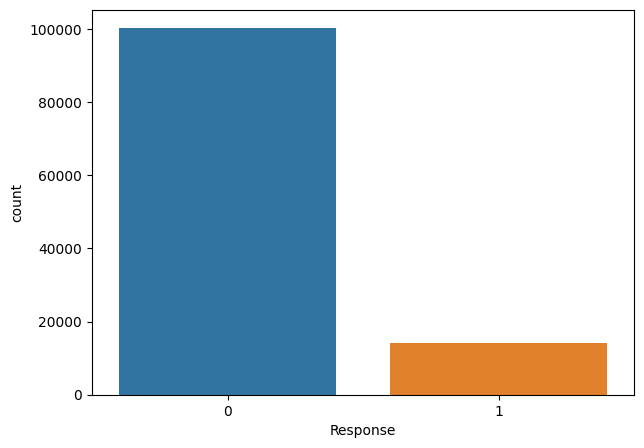

In [12]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
sns.countplot(x=main_df["Response"], order=[0,1], ax=ax)

### Predictor Variables

In [ ]:
main_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [13]:
# Identify columns which are not numerical:
categorical = [col for col in main_df.columns if main_df[col].dtype =='object']
categorical

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [14]:
show_nan_counts(main_df)

,counts,percentage
id,0,0.0
Gender,0,0.0
Age,0,0.0
Driving_License,0,0.0
Region_Code,0,0.0
Previously_Insured,0,0.0
Vehicle_Age,0,0.0
Vehicle_Damage,0,0.0
Annual_Premium,0,0.0
Policy_Sales_Channel,0,0.0


___
#### Correlation Plot for Basic Columns

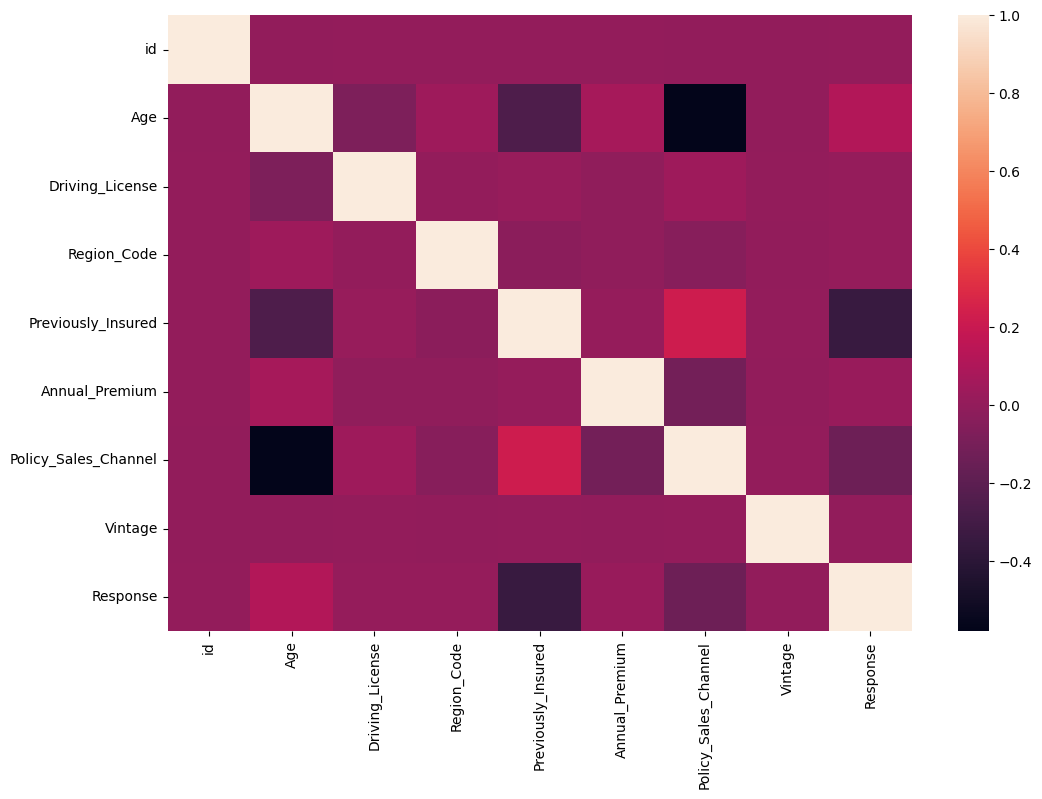

In [ ]:
show_heatmap(main_df)

<Axes: xlabel='Age', ylabel='Density'>

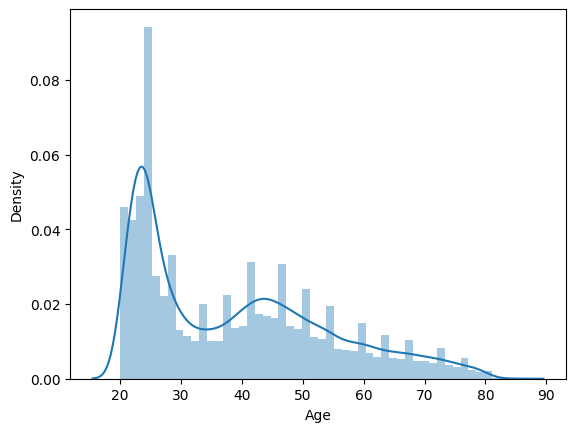

In [15]:
sns.distplot(main_df['Age'])

<Axes: xlabel='Vintage', ylabel='Density'>

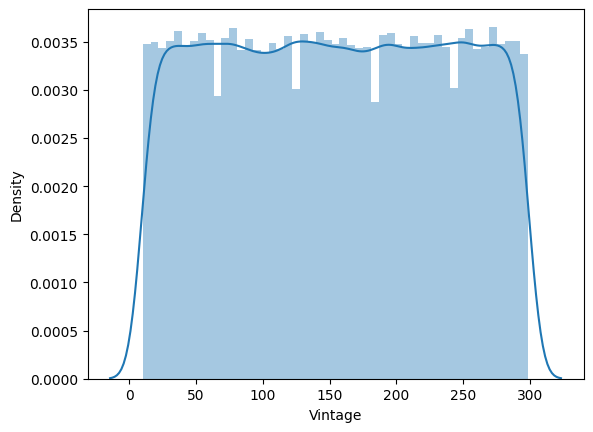

In [16]:
sns.distplot(main_df['Vintage'])

<Axes: xlabel='Annual_Premium', ylabel='Density'>

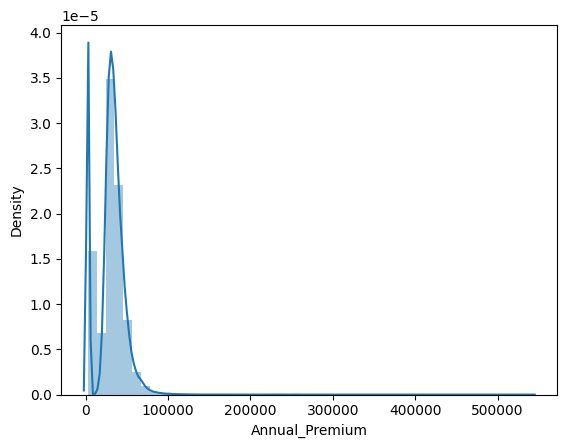

In [17]:
sns.distplot(main_df['Annual_Premium'])

___
<a name="pre-processing"></a>
## (4) Data Pre-Processing and Transformation

In [18]:
main_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,200223,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72,0
1,49767,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102,0
2,172202,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90,0
3,160714,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268,0
4,53273,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265,0


In [19]:
def preprocess_data(df):
    # Label encode gender
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1}).astype(int)
    
    # Convert Region_code and Policy_Sales_Channel into categoricals (Object)
    df['Region_Code'] = df['Region_Code'].apply(lambda x: str(int(x)))
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(lambda x: str(int(x)))
    
    # One hot encoding of categorical variables (with drop first)
    df = pd.get_dummies(df, drop_first=True)
    
    # Rename vehicle columns
    df = df.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1Y", 
                            "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2Y"})
    df['Vehicle_Age_lt_1Y'] = df['Vehicle_Age_lt_1Y'].astype('int')
    df['Vehicle_Age_gt_2Y'] = df['Vehicle_Age_gt_2Y'].astype('int')
    
    # Drop ID column
    df = df.drop('id',axis=1)
    
    return df

In [20]:
main_df = preprocess_data(main_df)

### Train Test Split

In [21]:
# Shuffle your dataset 
shuffle_df = main_df.sample(frac=1, random_state=1)

# Define a size for your train set (80:20)
train_size = int(0.8 * len(main_df))

# Split your dataset 
train_df = shuffle_df[:train_size]
test_df = shuffle_df[train_size:]

### Scale Data

In [22]:
def scale_data(df, train):
    # Performing normalization
    numerical_features = ['Age', 'Vintage', 'Annual_Premium']
    
    if train:
        mm = MinMaxScaler() 
        df[numerical_features] = mm.fit_transform(df[numerical_features])
        pickle.dump(mm, open("./data/minmax_scaler.pkl", 'wb'))
    else:
        mm = pickle.load(open("./data/minmax_scaler.pkl", 'rb'))
        df[numerical_features] = mm.transform(df[numerical_features])
        
    return df

In [23]:
train_df = scale_data(train_df, train=True)
test_df = scale_data(test_df, train=False)

In [24]:
assert len(train_df.columns) == len(test_df.columns)

In [25]:
train_df.head()

,Gender,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Region_Code_1,Region_Code_10,Region_Code_11,...,Policy_Sales_Channel_90,Policy_Sales_Channel_91,Policy_Sales_Channel_92,Policy_Sales_Channel_93,Policy_Sales_Channel_94,Policy_Sales_Channel_95,Policy_Sales_Channel_96,Policy_Sales_Channel_97,Policy_Sales_Channel_98,Policy_Sales_Channel_99
83163,0,0.000000,1,0,0.043928,0.958478,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36490,0,0.415385,1,1,0.068139,0.820069,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21633,0,0.415385,1,0,0.062545,0.854671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62657,0,0.030769,1,0,0.000000,0.979239,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98694,0,0.430769,1,0,0.102691,0.532872,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


___
### Export processed datasets

In [27]:
train_df.to_csv('data/processed/train.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)